# Complex Bayesian Network notebook

#### Import dependencies

In [1]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [2]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data import and cleaning

#### Import BigPerf data

In [3]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [4]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [5]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [6]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['Very Low', 'Low', 'High', 'Very-high']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 4, labels=tertile_labels, ordered=True)

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

#### Descritise data into catagories

In [7]:
# Discretise BigPerf dataset
cat_df = split_tertiles(df)

cat_df.head()

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,Very-high,Very Low,Very Low,Very Low,Very-high,Very Low,Low,Very-high,Very Low,Very-high,Very Low,Very Low,Low
1,Very-high,Very Low,Very Low,Very Low,Very-high,Very Low,Very Low,Very Low,Low,Very Low,Very-high,Very Low,Very Low
2,Very-high,Very Low,Very Low,Very Low,High,Very Low,High,Very-high,Very Low,Very-high,Very Low,Very-high,Low
3,Very-high,Very Low,Very Low,Very Low,High,Very Low,Very Low,Very Low,Very Low,High,Very Low,Very-high,Very Low
4,Very-high,Very Low,Very Low,Very Low,High,Very Low,High,Very-high,Very Low,High,Very Low,Very-high,Low


In [8]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

In [10]:
from pgmpy.estimators import TreeSearch

# learn graph structu
est = TreeSearch(training_data, root_node="HBW")
dag = est.estimate(estimator_type="tan", class_node="TT")

Building tree:   0%|          | 0/78.0 [00:00<?, ?it/s]

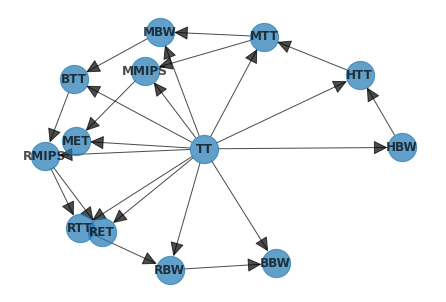

In [11]:
G = nx.DiGraph()
G.add_edges_from(dag.edges)
G.add_nodes_from(dag.nodes)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph

In [12]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator, ExpectationMaximization
from pgmpy.models import BayesianModel, BayesianNetwork

model = BayesianNetwork(dag)

model.fit(data=training_data, estimator=MaximumLikelihoodEstimator)

model.get_cpds()

[<TabularCPD representing P(HBW:2 | TT:4) at 0x1fedbeafc10>,
 <TabularCPD representing P(HTT:2 | HBW:2, TT:4) at 0x1fef340f040>,
 <TabularCPD representing P(MTT:4 | HTT:2, TT:4) at 0x1fef730ea10>,
 <TabularCPD representing P(MBW:4 | MTT:4, TT:4) at 0x1fef735cb50>,
 <TabularCPD representing P(MMIPS:4 | MTT:4, TT:4) at 0x1fef735c580>,
 <TabularCPD representing P(BTT:2 | MBW:4, TT:4) at 0x1fef5159360>,
 <TabularCPD representing P(MET:4 | MMIPS:4, TT:4) at 0x1fef340f760>,
 <TabularCPD representing P(RMIPS:4 | BTT:2, TT:4) at 0x1fef515b250>,
 <TabularCPD representing P(RET:2 | RMIPS:4, TT:4) at 0x1fef730e260>,
 <TabularCPD representing P(RTT:3 | RMIPS:4, TT:4) at 0x1fef730e8f0>,
 <TabularCPD representing P(RBW:3 | RTT:3, TT:4) at 0x1fef730e860>,
 <TabularCPD representing P(BBW:2 | RBW:3, TT:4) at 0x1fef730e740>,
 <TabularCPD representing P(TT:4) at 0x1fef4fcf3a0>]

In [13]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

for column in testing_data:
    predict_data = testing_data.copy()
    predict_data.drop(column, axis=1, inplace=True)
    y_pred = model.predict(predict_data)

    accuracy = accuracy_score(testing_data[column], y_pred)
    
    # if len(testing_data[column].unique()) == 2:
    #     precision = precision_score(testing_data[column], y_pred, pos_label='Low') #pos_label=testing_data[column].unique()
    #     f1 = f1_score(testing_data[column], y_pred, pos_label='Low')
    #     recall = recall_score(testing_data[column], y_pred, pos_label='Low')

    # else:
    #     precision = precision_score(testing_data[column], y_pred, average='micro') #pos_label=testing_data[column].unique()
    #     f1 = f1_score(testing_data[column], y_pred, average='micro')
    #     recall = recall_score(testing_data[column], y_pred, average='micro')

    #print(f'{column} F1 score: {f1}')
    print(f'{column} Accuracy score: {accuracy}')
    #print(f'{column} Precision score: {precision}')
    #print(f'{column} Recall score: {recall}')

  0%|          | 0/150 [00:00<?, ?it/s]

HBW Accuracy score: 0.9940944881889764


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/152 [00:00<?, ?it/s]

HTT Accuracy score: 0.9921259842519685


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MMIPS Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MET Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/138 [00:00<?, ?it/s]

MBW Accuracy score: 0.9035433070866141


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/101 [00:00<?, ?it/s]

MTT Accuracy score: 0.7421259842519685


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/134 [00:00<?, ?it/s]

RMIPS Accuracy score: 0.8917322834645669


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

RET Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

RBW Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/141 [00:00<?, ?it/s]

RTT Accuracy score: 0.8996062992125984


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

BBW Accuracy score: 1.0


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

BTT Accuracy score: 0.9330708661417323


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/137 [00:00<?, ?it/s]

TT Accuracy score: 0.844488188976378


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


In [14]:
f1 = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=model, data=testing_data)
ss = structure_score(model=model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Strcture score: {ss}')

F1 score: 0.0
Accuracy score: 0.6538461538461539
Precision score: 0.0
Recall score: 0.0
Log-likilihood score: -inf
Strcture score: -3386.4803799617093


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\pgmpy\metrics\bn_inference.py:91: RuntimeWarning: divide by zero encountered in log
  return np.log(probability_node)


In [15]:
def store_metrics(metrics_file_name, model_name, f1, accuracy, precision, recall, log_likelihood_score, structure_score):
    try: 
        df = pd.read_csv('Model-metrics.csv', header=0, index_col=False)
    except:
        df_columns = ['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'Log likelihood score', 'Structure score']

        df = pd.DataFrame(columns=df_columns)

    else:
        df = df[df.Model != model_name]
        
    new_row = {'Model': model_name, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Log likelihood score': log_likelihood_score, 'Structure score': structure_score}

    df = df.append(new_row, ignore_index=True)

    # Write to file
    df.to_csv(metrics_file_name, index=False)


In [16]:
model_name = 'TAN'
metrics_file_name = 'Model-metrics.csv'

store_metrics(metrics_file_name=metrics_file_name, model_name=model_name, f1=f1, accuracy=acc, precision=pr, recall=recall, log_likelihood_score=ls, structure_score=ss)

C:\Users\KEIRMC~1\AppData\Local\Temp/ipykernel_15372/3521155595.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [17]:
print(f'Check model: {model.check_model()}\n')
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of HBW:
+----------------+-----+--------------------+
| TT             | ... | TT(Very-high)      |
+----------------+-----+--------------------+
| HBW(Very Low)  | ... | 0.6807228915662651 |
+----------------+-----+--------------------+
| HBW(Very-high) | ... | 0.3192771084337349 |
+----------------+-----+--------------------+ 

CPT of HTT:
+----------------+-----+----------------+----------------+
| HBW            | ... | HBW(Very-high) | HBW(Very-high) |
+----------------+-----+----------------+----------------+
| TT             | ... | TT(Very Low)   | TT(Very-high)  |
+----------------+-----+----------------+----------------+
| HTT(Very Low)  | ... | 1.0            | 1.0            |
+----------------+-----+----------------+----------------+
| HTT(Very-high) | ... | 0.0            | 0.0            |
+----------------+-----+----------------+----------------+ 

CPT of MTT:
+----------------+-----+---------------------+
| HTT            | ... | HTT(Very-high)  